In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import glob, cv2, os, sys

from tqdm import tqdm
from matplotlib import colors

torch.cuda.empty_cache()

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Model Architecture

In [3]:
class SE_Block(nn.Module):
  "credits: https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py#L4"
  def __init__(self, c, r=16):
    super().__init__()
    self.squeeze = nn.AdaptiveAvgPool2d(1)
    self.excitation = nn.Sequential(
        nn.Linear(c, c // r, bias=False),
        nn.ReLU(inplace=True),
        nn.Linear(c // r, c, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    bs, c, _, _ = x.shape
    y = self.squeeze(x).view(bs, c)
    y = self.excitation(y).view(bs, c, 1, 1)
    return x * y.expand_as(x)

In [4]:
class SEResnet(nn.Module):
  def __init__(self, inplanes, kernels, stride, padding = 1, r = 16):
    super().__init__()
    self.sequence = nn.Sequential(
      nn.Conv2d(inplanes, kernels, kernel_size = 3, stride = stride, padding = padding),
      nn.BatchNorm2d(num_features = kernels),
      nn.ReLU(inplace = True),
      nn.Conv2d(kernels, kernels, kernel_size = 3, stride = stride, padding = padding),
      nn.BatchNorm2d(num_features = kernels),
      SE_Block(kernels, r)

    )
    self.ReLU = nn.ReLU(inplace = True)
  def forward(self, x):
    out = self.sequence(x)
    out += x
    out = self.ReLU(out)
    return out

In [5]:
class conv3x3_bn_relu(nn.Module):
  def __init__(self, inplanes, kernels, stride, padding = 1):
    super().__init__()

    self.sequence = nn.Sequential(
      nn.Conv2d(inplanes, kernels, kernel_size = 3, stride = stride, padding = padding),
      nn.BatchNorm2d(num_features = kernels),
      nn.ReLU(inplace = True)

    )

  def forward(self, x):

    return self.sequence(x)

In [6]:
class down(nn.Module):
  def __init__(self, inplanes, kernels, stride, padding = 1, pooling = True, r = 16):
    super().__init__()
    self.conv = nn.Sequential(
        conv3x3_bn_relu(inplanes, kernels, stride, padding),
        SEResnet(kernels, kernels, stride, padding, r),
        SEResnet(kernels, kernels, stride, padding, r),
    )
    self.max_pooling = nn.MaxPool2d(2) if pooling else nn.Identity()

  def forward(self, x):
    return self.conv(self.max_pooling(x))

In [7]:
class Attention_block(nn.Module):
  def __init__(self, F_g, F_l, F_int):
    super().__init__()
    self.W_g = nn.Sequential(
      nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
      nn.BatchNorm2d(F_int)
    )

    self.W_x = nn.Sequential(
      nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
      nn.BatchNorm2d(F_int)
    )

    self.psi = nn.Sequential(
      nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
      nn.BatchNorm2d(1),
      nn.Sigmoid()
    )

    self.relu = nn.ReLU(inplace=True)

  def forward(self, g, x):
    psi = self.relu(self.W_g(g) + self.W_x(x))
    psi = self.psi(psi)

    return x * psi

In [8]:
class up(nn.Module):
  def __init__(self, inplanes, kernels, stride = 1, padding = 1, bilinear = True):
    super().__init__()
    if bilinear :
      self.up = nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners = True)
      self.conv = nn.Sequential(
        conv3x3_bn_relu(inplanes + inplanes // 2, kernels, stride, padding),
        conv3x3_bn_relu(kernels, kernels, stride, padding),
      )
    else:
      self.up = nn.ConvTranspose2d(inplanes, inplanes//2, kerenls_size = 2, stride = stride)

      self.conv = nn.Sequential(
        conv3x3_bn_relu(inplanes, kernels, stride, padding),
        conv3x3_bn_relu(kernels, kernels, stride, padding),
      )
    self.AG = Attention_block(inplanes, kernels, kernels)


  def forward(self, x1, x2):
    x2 = self.up(x2)
    att = self.AG(x2, x1)
    return self.conv(torch.cat([att, x2], dim = 1))


In [9]:
class myModel(nn.Module):
  def __init__(self, n_channel = 1, n_class = 1, bilinear = True):
    super().__init__()
    self.down1 = down(n_channel, 12, 1, pooling = False)
    self.down2 = down(12, 24, 1)
    self.down3 = down(24, 48, 1)
    self.down4 = down(48, 96, 1)
    self.down5 = down(96, 192, 1)
    self.up1 = up(96*2, 96, 1, bilinear = bilinear)
    self.up2 = up(48*2, 48, 1, bilinear = bilinear)
    self.up3 = up(24*2, 24, 1, bilinear = bilinear)
    self.up4 = up(12*2, 12, 1, bilinear = bilinear)
    self.out = nn.Conv2d(12, n_class, 3, 1, padding = 1)
  def forward(self, x):
    x1 = self.down1(x)
    x2 = self.down2(x1)
    x3 = self.down3(x2) #channel:48
    x4 = self.down4(x3) #channel:96   shape: torch.Size([1, 96, 152, 64])
    x5 = self.down5(x4) #channel:192   shape: torch.Size([1, 192, 76, 32])

    x = self.up1(x4, x5) #channel:96
    x = self.up2(x3, x) #channel:48
    x = self.up3(x2, x) #channel:24
    x = self.up4(x1, x) #channek:12
    logit = self.out(x)
    return logit

# Dataset & Dataloader

In [10]:
from torch.utils.data import Dataset, DataLoader
images = glob.glob('/content/drive/My Drive/Vertebral Segmentation/data/f01/image/*.png')
labels = glob.glob('/content/drive/My Drive/Vertebral Segmentation/data/f01/label/*.png')

images.sort(), labels.sort()

(None, None)

In [11]:
!pip install albumentations
import albumentations as albu
from albumentations.pytorch import ToTensorV2

def get_simple_training_augmetation():
  aug = [
         albu.Flip(p = 0.5),
         albu.ShiftScaleRotate(shift_limit = 0.1, rotate_limit= 30, border_mode=cv2.BORDER_CONSTANT, p = 0.8),
         albu.PadIfNeeded(1216, 512, always_apply = True, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(transpose_mask = True)
  ]
  return albu.Compose(aug)

def get_complex_training_augmetation():
  aug = [
         albu.Flip(p = 0.5),
         albu.ShiftScaleRotate(shift_limit = 0.1, rotate_limit= 30, border_mode=cv2.BORDER_CONSTANT, p = 0.8),

         albu.OneOf([
            albu.ElasticTransform(p = 0.8),
            albu.GridDistortion(p = 0.5)
         ], p = 0.8),

         albu.OneOf([
           albu.IAAAdditiveGaussianNoise(p=0.9),
           albu.GaussNoise(p=0.6),
         ], p = 0.8),

         albu.PadIfNeeded(1216, 512, always_apply = True, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(transpose_mask = True)
  ]
  return albu.Compose(aug)

def get_validation_augmentation():
  aug = [
         albu.PadIfNeeded(1216, 512, always_apply = True, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(transpose_mask = True)

  ]
  return albu.Compose(aug)

In [12]:
class AugmentedImageDataset(Dataset):
  def __init__(self, images, labels, augmentation = None):
    super().__init__()
    self.images = images
    self.labels = labels
    self.augmentation = augmentation
  def __getitem__(self, index):

    # get path
    img = self.images[index]
    label = self.labels[index]

    # read image
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label, cv2.IMREAD_GRAYSCALE)

    # 增加channel這個維度
    img = img[:,:,np.newaxis]
    label = label[:,:,np.newaxis]

    # Augmentation
    if(self.augmentation):
      sampled = self.augmentation(image = img, mask = label)
      img = sampled['image']
      label = sampled['mask']


    return torch.div(img, 255), torch.div(label, 255)

  def __len__(self):
    return len(self.images)

# Training Setting

In [13]:
class Dice(nn.Module):
  def __init__(self, eps = 1e-7, threshold = 0.5):
    super().__init__()
    self.eps = eps
    self.threshold = threshold
    self.activation = torch.sigmoid

  @property
  def __name__(self):
    return 'Dice'

  def _threshold(self, x):
    return (x > self.threshold).type(x.dtype)

  def forward(self, y_pr, y_gt):

    y_pr = self.activation(y_pr)
    y_pr = self._threshold(y_pr)

    tp = torch.sum(y_gt * y_pr)
    fp = torch.sum(y_pr) - tp
    fn = torch.sum(y_gt) - tp

    score = torch.div((2 * tp + self.eps), (2 * tp +  fn + fp + self.eps))
    return score

class AverageValueMeter(object):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n = 1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 1:
            self.mean = 0.0 + self.sum
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

def to_string(logs):
  str_logs = ['{} - {:.4}'.format(k, v) for k, v in logs.items()]
  s = ', '.join(str_logs)
  return s

In [14]:
epochs = 60
lr = 5e-5
weight_decay = 1e-5
kfold = 3
save_path = '/content/drive/My Drive/Vertebral Segmentation/weight'

bce_loss = nn.BCEWithLogitsLoss() #先做normalize
metric = Dice()
optimizer = torch.optim.Adam

device = 'cuda' if torch.cuda.is_available else 'cpu'

batch_size = 4
num_workers = 2
shuffle = True
drop_last = True
pin_memory = True


# Training & Validation

In [15]:
def get_train_valid_data(fold):

    train_images = glob.glob('/content/drive/My Drive/Vertebral Segmentation/data/f0{}/image/*.png'.format((fold+1)%3+1)) +\
                  glob.glob('/content/drive/My Drive/Vertebral Segmentation/data/f0{}/image/*.png'.format((fold+2)%3+1))

    train_labels = glob.glob('/content/drive/My Drive/Vertebral Segmentation/data/f0{}/label/*.png'.format((fold+1)%3+1)) +\
                  glob.glob('/content/drive/My Drive/Vertebral Segmentation/data/f0{}/label/*.png'.format((fold+2)%3+1))

    valid_images = glob.glob('/content/drive/My Drive/Vertebral Segmentation/data/f0{}/image/*.png'.format(fold%3+1))
    valid_labels = glob.glob('/content/drive/My Drive/Vertebral Segmentation/data/f0{}/label/*.png'.format(fold%3+1))


    train_images.sort()
    train_labels.sort()
    valid_images.sort()
    valid_labels.sort()

    return (train_images, train_labels), (valid_images, valid_labels)

In [ ]:
k_fold_best = [0] * kfold


for fold in range(kfold):

  (train_images, train_labels), (valid_images, valid_labels) = get_train_valid_data(fold)

  train_dataset = AugmentedImageDataset(train_images, train_labels, get_complex_training_augmetation())
  valid_dataset = AugmentedImageDataset(valid_images, valid_labels, get_validation_augmentation())
  train_loader = DataLoader(train_dataset, batch_size, shuffle, num_workers = num_workers, pin_memory = pin_memory)
  valid_loader = DataLoader(valid_dataset, batch_size, shuffle, num_workers = num_workers, pin_memory = pin_memory)

  seg_model = myModel(n_channel = 1)
  opt = optimizer(seg_model.parameters(), lr = lr, weight_decay = weight_decay)

  seg_model.to(device)
  metric.to(device)

  model_name = os.path.join(save_path, str(fold+1), 'Unet.h5')

  max_score = 0

  for epoch in range(epochs):
    print('Epoch: %d' %(epoch+1))

    #training phase
    seg_model.train() #!!!!非常重要!!!!

    train_logs = {}
    loss_meter = AverageValueMeter()
    metric_meter = AverageValueMeter()
    with tqdm(train_loader, desc = 'Train', file = sys.stdout) as iterator:
      for imgs, gts in iterator:

        imgs = imgs.to(device, dtype = torch.float)
        gts = gts.to(device, dtype = torch.float)
        preds = seg_model(imgs)
        loss = bce_loss(preds, gts)

        loss.backward()
        opt.step()
        opt.zero_grad()

        loss_val = loss.cpu().detach().numpy()
        loss_meter.add(loss_val)
        train_logs.update({'CrossEntropy': loss_meter.mean})

        metric_val = metric(preds, gts).cpu().detach().numpy()
        metric_meter.add(metric_val)
        train_logs.update({metric.__name__: metric_meter.mean})

        iterator.set_postfix_str(to_string(train_logs))


    #validation phase
    seg_model.eval()

    val_logs = {}
    loss_meter = AverageValueMeter()
    metric_meter = AverageValueMeter()
    with tqdm(valid_loader, desc = 'Valid', file = sys.stdout) as iterator:
      for imgs, gts in iterator:
        with torch.no_grad(): #!!!不算gradient!!!

          imgs = imgs.to(device, dtype = torch.float)
          gts = gts.to(device, dtype = torch.float)

          preds = seg_model(imgs)
          loss = bce_loss(preds, gts)

        loss_val = loss.cpu().detach().numpy()
        loss_meter.add(loss_val)
        val_logs.update({'CrossEntropy': loss_meter.mean})

        metric_val = metric(preds, gts).cpu().detach().numpy()
        metric_meter.add(metric_val)
        val_logs.update({metric.__name__: metric_meter.mean})

        iterator.set_postfix_str(to_string(val_logs))


    if max_score < val_logs['Dice']:
      max_score = val_logs['Dice'];
      k_fold_best[fold] = val_logs['Dice']

      torch.save(seg_model.state_dict(), model_name)  #儲存weight
      print('Model Save !!!!')

print('\n')
print('K-Fold average Dice : %0.4f' %(sum(k_fold_best) / len(k_fold_best)))

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 1
Valid: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s, CrossEntropy - 0.724, Dice - 0.274]
Model Save !!!!
Epoch: 2
Valid: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s, CrossEntropy - 0.7189, Dice - 0.2739]
Epoch: 3
Valid: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s, CrossEntropy - 0.7132, Dice - 0.2751]
Model Save !!!!
Epoch: 4
Valid: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s, CrossEntropy - 0.6842, Dice - 0.3453]
Model Save !!!!
Epoch: 5
Valid: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s, CrossEntropy - 0.6432, Dice - 0.3662]
Model Save !!!!
Epoch: 6
Valid: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s, CrossEntropy - 0.6302, Dice - 0.387]
Model Save !!!!
Epoch: 7
Valid: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s, CrossEntropy - 0.6407, Dice - 0.4342]
Model Save !!!!
Epoch: 8
Valid: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s, CrossEntropy - 0.5978, Dice - 0.5222]
Model Save !!!!
Epoch: 9
Valid: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s, CrossEntropy - 0.5821, Dice -

# Prediction

In [16]:
images = glob.glob('/content/drive/My Drive/Vertebral Segmentation/data/f01/image/*.png')
labels = glob.glob('/content/drive/My Drive/Vertebral Segmentation/data/f01/label/*.png')
images.sort(), labels.sort()

valid_dataset = AugmentedImageDataset(images, labels, get_validation_augmentation())

(-0.5, 499.5, 1199.5, -0.5)

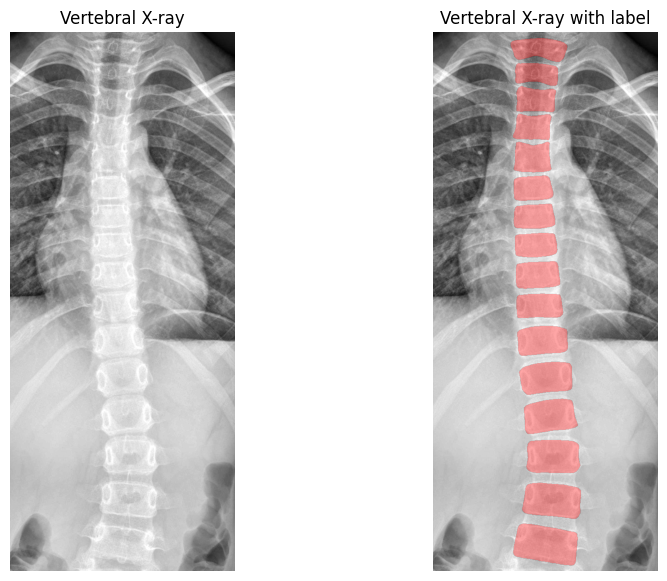

In [18]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title('Vertebral X-ray')
img = cv2.imread(images[11], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
label = cv2.imread(labels[11], cv2.IMREAD_GRAYSCALE)
rgba_label = cv2.cvtColor(label, cv2.COLOR_GRAY2RGBA)
rgba_label[label == 0, 3] = 0  # 將灰度值為0的像素的alpha通道設置為0，即透明
rgba_label[label == 255, :3] = [255, 0, 0]  # 將灰度值為255的像素的RGB值設置為紅色

plt.title('Vertebral X-ray with label')
plt.imshow(img, cmap='gray')
plt.imshow(rgba_label, alpha=0.35)
plt.axis('off')

In [19]:
# Load pre-trained weights
seg_model = myModel(n_channel = 1)
seg_model.eval()
seg_model.load_state_dict(torch.load('/content/drive/My Drive/Vertebral Segmentation/weight/1/Unet.h5'))

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


<All keys matched successfully>

In [20]:
with torch.no_grad():
  img, label = valid_dataset[11]
  pred = seg_model(img.unsqueeze(0))
  pred = torch.sigmoid(pred).detach().numpy()
  pred = np.where(pred > 0.5, 1, 0)

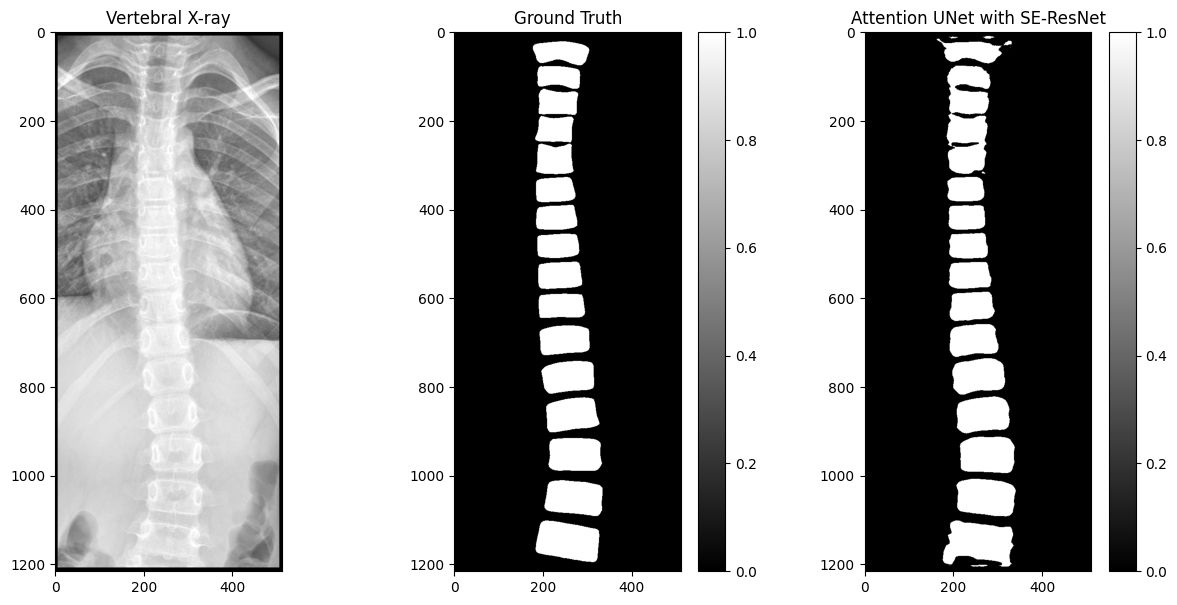

In [21]:
plt.figure(figsize=(15, 7))

#plot input img
plt.subplot(1, 3, 1)
plt.title('Vertebral X-ray')
plt.imshow(img.squeeze(0), cmap = 'gray')

#plot label
plt.subplot(1, 3, 2)
plt.title('Ground Truth')
plt.imshow(label.squeeze(0), cmap = 'gray')
plt.colorbar()

#plot pred
plt.subplot(1, 3, 3)
plt.title('Attention UNet with SE-ResNet')
plt.imshow(pred.squeeze((0, 1)), cmap = 'gray')
plt.colorbar()
